QC: check that states was reconstructed correctly and correlate cossim with edge placement on the tree

In [1]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean
from Bio import SeqIO
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary, calculate_mutspec
from pymutspec.io import read_rates, GenesStates
from pymutspec.constants import possible_sbs192, possible_sbs12

%matplotlib inline

### Correlate edge cossim versus length

In [2]:
cossim12 = pd.read_csv("../data/alisim/mam_cossim12.csv")
cossim12["mdl"] = cossim12.RawCond.apply(lambda x: x.split("_")[0])
cossim12["seq"] = cossim12.RawCond.apply(lambda x: x.split("_")[2])
cossim12["replica"] = cossim12.RawCond.apply(lambda x: x.split("_")[-1])

cossim192 = pd.read_csv("../data/alisim/mam_cossim192.csv")
cossim192["mdl"] = cossim192.RawCond.apply(lambda x: x.split("_")[0])
cossim192["seq"] = cossim192.RawCond.apply(lambda x: x.split("_")[2])
cossim192["replica"] = cossim192.RawCond.apply(lambda x: x.split("_")[-1])


In [3]:
from ete3 import PhyloTree

path_to_tree = "../data/alisim/generations_mam/gtr_mam_cytb_replica_1.full.treefile"
tree = PhyloTree(path_to_tree, format=1)

In [4]:
edges = []
for i, node in enumerate(tree.iter_descendants()):
    # print(node.name, node.up.name, node.dist, )
    closest_leaf, d_to_leaf = node.up.get_closest_leaf()
    edges.append([
        node.up.name, 
        node.name, 
        node.dist, 
        closest_leaf.name, 
        d_to_leaf,
    ])
    # if i == 10:
    #     break

edges_df = pd.DataFrame(edges, columns=["RefNode", "AltNode", "d", "closest_leaf", "d_to_leaf"])
edges_df

,RefNode,AltNode,d,closest_leaf,d_to_leaf
0,ROOT,OUTGRP,1.50000,OUTGRP,1.50000
1,ROOT,Node4705,0.01000,OUTGRP,1.50000
2,Node4705,Node2,1.35799,gerbillus_occiduus,2.02331
3,Node4705,Node4,0.60502,gerbillus_occiduus,2.02331
4,Node2,Node3,0.54029,tachyglossus_aculeatus,0.66537
...,...,...,...,...,...
9405,Node1833,artibeus_planirostris_grenadensis,0.00338,artibeus_planirostris_fallax,0.00338
9406,Node3018,peromyscus_polionotus_peninsularis,0.00077,peromyscus_polionotus_peninsularis,0.00077
9407,Node3018,peromyscus_polionotus_trissyllepsis,0.00077,peromyscus_polionotus_peninsularis,0.00077
9408,Node3019,peromyscus_polionotus_ammobates,0.00092,peromyscus_polionotus_ammobates,0.00092


In [5]:
cossim12 = cossim12.merge(edges_df[["AltNode", "d", "d_to_leaf"]], on="AltNode")
cossim192 = cossim192.merge(edges_df[["AltNode", "d", "d_to_leaf"]], on="AltNode")

In [6]:
cossim12.shape, cossim192.shape

((1297353, 9), (717241, 9))

In [28]:
cossim12.corr("spearman")

,CosSim12,d,d_to_leaf
CosSim12,1.000000,0.08253,-0.168796
d,0.082530,1.00000,0.634600
d_to_leaf,-0.168796,0.63460,1.000000


In [29]:
cossim192.corr("spearman")

,CosSim192,d,d_to_leaf
CosSim192,1.000000,-0.001835,-0.233540
d,-0.001835,1.000000,0.648762
d_to_leaf,-0.233540,0.648762,1.000000


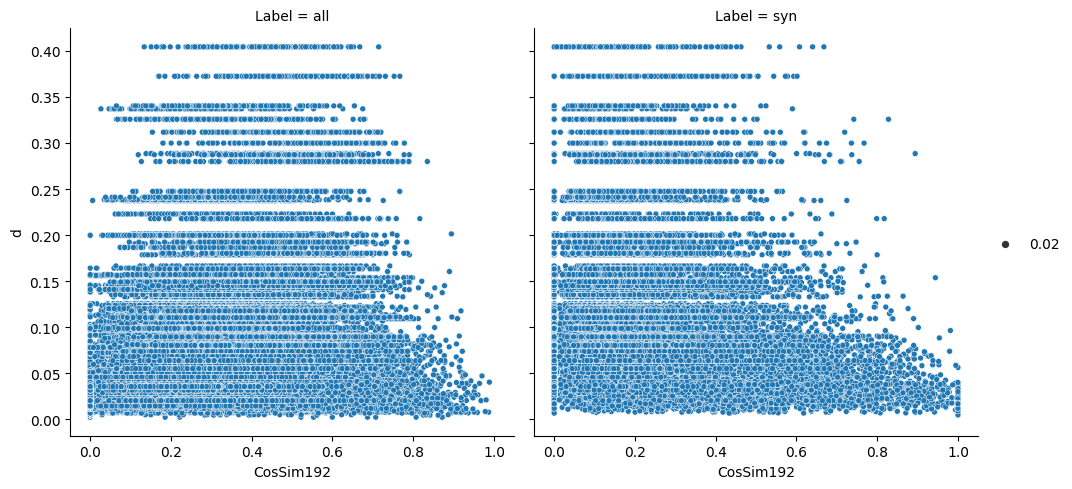

In [14]:
sns.relplot(data=cossim192.head(100000), x="CosSim192", y="d", col="Label",
            size=0.02, 
        #    col="mdl", row="seq", 
)

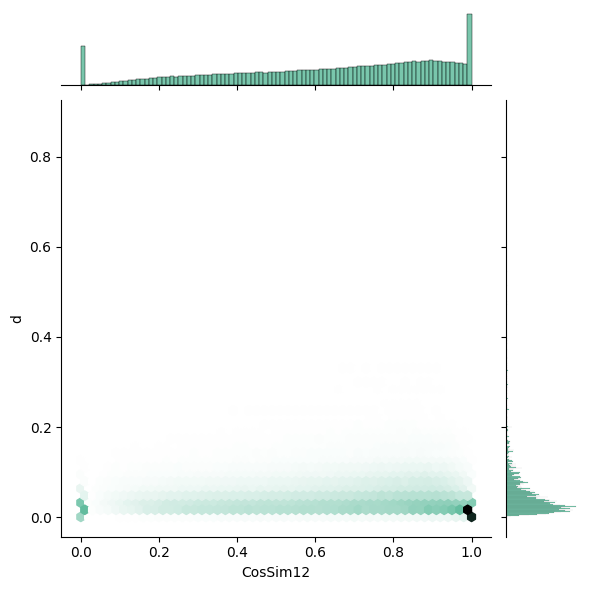

In [30]:
sns.jointplot(data=cossim12[cossim12.Label == "syn"], x="CosSim12", y="d", kind="hex", color="#4CB391")

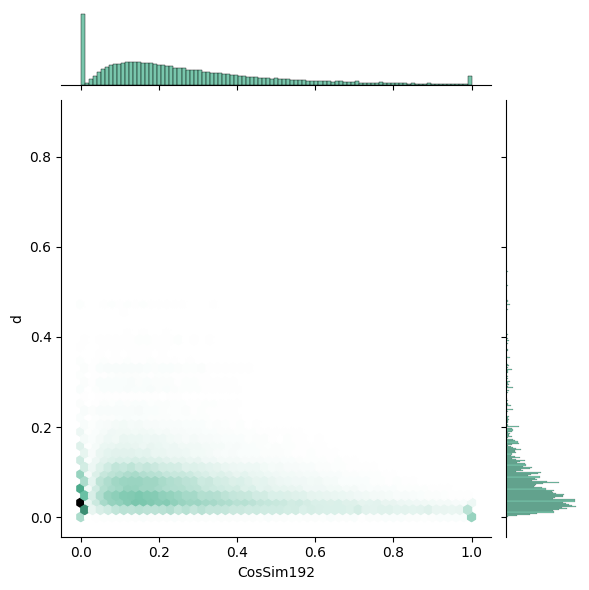

In [32]:
sns.jointplot(data=cossim192[cossim192.Label == "all"], x="CosSim192", y="d", kind="hex", color="#4CB391")

**no correlation**

### derive entropy of anc states

In [105]:
accuracy  = []

colnames = ['Node', 'Site', 'State', 'p_A', 'p_C', 'p_G', 'p_T']
dtypes = {
    'Site': np.int32,
    'p_A': np.float32,
    'p_C': np.float32,
    'p_G': np.float32,
    'p_T': np.float32,
}
i = 0
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_mam/*")):
    i += 1
    cond = d.split("/")[-1]
    path_to_rec_states = os.path.join(d, "IQTREE/iqtree_anc.state")
    path_to_rec_rates = os.path.join(d, "IQTREE/anc.rate")
    path_to_gt_states  = f"../data/alisim/generations_mam/{cond}.fa"


    if os.path.exists(path_to_gt_states) and os.path.exists(path_to_rec_states):
        rec = pd.read_csv(path_to_rec_states, sep="\t", usecols=colnames, dtype=dtypes, index_col=[0,1])
        rate = pd.read_csv(path_to_rec_rates, sep='\t', comment="#", index_col=0)
        rec = rec.merge(rate[["Cat"]], right_index=True, left_index=True)
        aln = SeqIO.parse(path_to_gt_states, "fasta")
        gt_data = []
        for seq in aln:
            node = seq.id
            if node.startswith("Node"):
                one = pd.DataFrame({
                    "Node":[node for _ in range(len(seq))], 
                    "Site":np.arange(1, len(seq)+1), 
                    "StateGt": list(seq.seq)})
                gt_data.append(one)
        gt = pd.concat(gt_data, ignore_index=True)
        # del gt_data
        df = rec.merge(gt, right_on=["Node", "Site"], left_index=True)
        # acc = (df.State == df.StateGt).sum() / len(df)
        df["is_eq"] = (df.State == df.StateGt).astype(np.int8)
        acc = df.groupby(["Node", "Cat"]).is_eq.value_counts(normalize=True).unstack()[1].rename("Acc").reset_index().assign(Cond=cond)
        accuracy.append(acc)
        # if acc < 0.9:
        #     print(f"WARNING! low accuracy: {acc:.3f} in {cond}")

    # if i == 6:
    #     break

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [34:53<00:00, 10.47s/it]


In [106]:
df = pd.concat(accuracy)
print(df.shape)
df.head()

(6538560, 4)


,Node,Cat,Acc,Cond
0,Node10,0,1.000000,gtr_mam_cytb_replica_18
1,Node10,1,1.000000,gtr_mam_cytb_replica_18
2,Node10,2,0.995000,gtr_mam_cytb_replica_18
3,Node10,3,0.972067,gtr_mam_cytb_replica_18
4,Node10,4,0.924051,gtr_mam_cytb_replica_18


In [117]:
df[df.Cat == 7].Cond.value_counts()

12.12_mam_cytb_replica_17    4704
gtr_mam_cytb_replica_45      4704
gtr_mam_cytb_replica_27      4704
Name: Cond, dtype: int64

In [125]:
df.groupby(["Cond", "Cat"]).Acc.describe().round(2)

count  mean   std   min   25%   50%   75%  max
Cond                     Cat                                                 
12.12_mam_cytb_replica_0 0    4704.0  1.00  0.00  1.00  1.00  1.00  1.00  1.0
                         1    4704.0  1.00  0.00  0.76  1.00  1.00  1.00  1.0
                         2    4704.0  1.00  0.01  0.47  1.00  1.00  1.00  1.0
                         3    4704.0  0.99  0.02  0.39  0.99  1.00  1.00  1.0
                         4    4704.0  0.98  0.03  0.33  0.98  1.00  1.00  1.0
...                              ...   ...   ...   ...   ...   ...   ...  ...
gtr_mam_rnd_replica_9    2    4704.0  0.99  0.02  0.64  0.99  1.00  1.00  1.0
                         3    4704.0  0.98  0.03  0.64  0.98  1.00  1.00  1.0
                         4    4704.0  0.96  0.06  0.52  0.96  0.99  1.00  1.0
                         5    4704.0  0.93  0.08  0.45  0.90  0.97  0.99  1.0
                         6    4704.0  0.86  0.13  0.43  0.77  0.90  0.97  1.0

[1390 rows x 8 columns]

<AxesSubplot:xlabel='Cat', ylabel='Acc'>

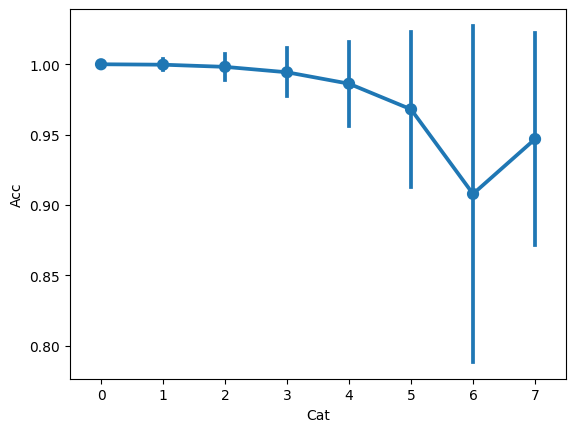

In [133]:
sns.pointplot(data=df, x="Cat", y="Acc", ci="sd", )

<AxesSubplot:xlabel='Cat', ylabel='Acc'>

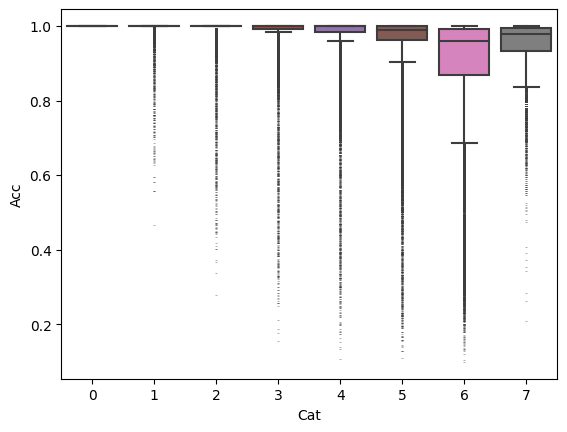

In [124]:
# plt.figure(figsize=(18, 6))
sns.boxplot(data=df, y="Acc", x="Cat", fliersize=0.1)